In [22]:
from layout import Layout, default_color_map

## Definition
The (logical) product is defined as $A \otimes B := (A, \tilde A \circ B)$.

In terms of the pseudo code:
```python
size = self.size() * other.cosize()
compl = self.complement(size)
compo = compl.composite(other)
return Layout.from_concate(self, compo)
```

It is best to illustrate the idea of a logical product using a 2D by-mode example as follows.

## 2D By-Mode Product

For 2D layout $A = (A_{s_1}, A_{s_2}):(A_{d_1}, A_{d_2})$ and $B = (B_{s_1}, B_{s_2}):(B_{d_1}, B_{d_2})$,
the product $A \otimes B$ will generate $B_{s_1} \times B_{s_2}$ tiles where the first tile is $A$.
And the resulting stride along the m-axis is $(A_{s_1} \times B_{d_1})$, and $(A_{s_2} \times B_{d_2})$ along the n-axis.

((2, 3), (5, 4)):((5, 40), (1, 50))

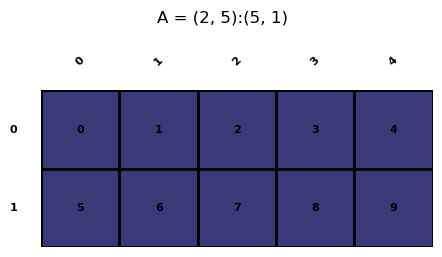

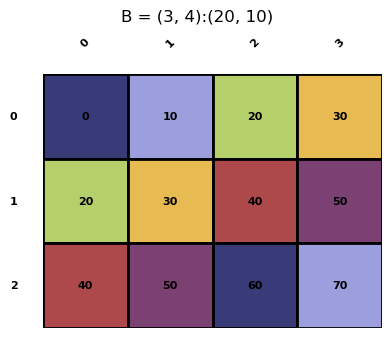

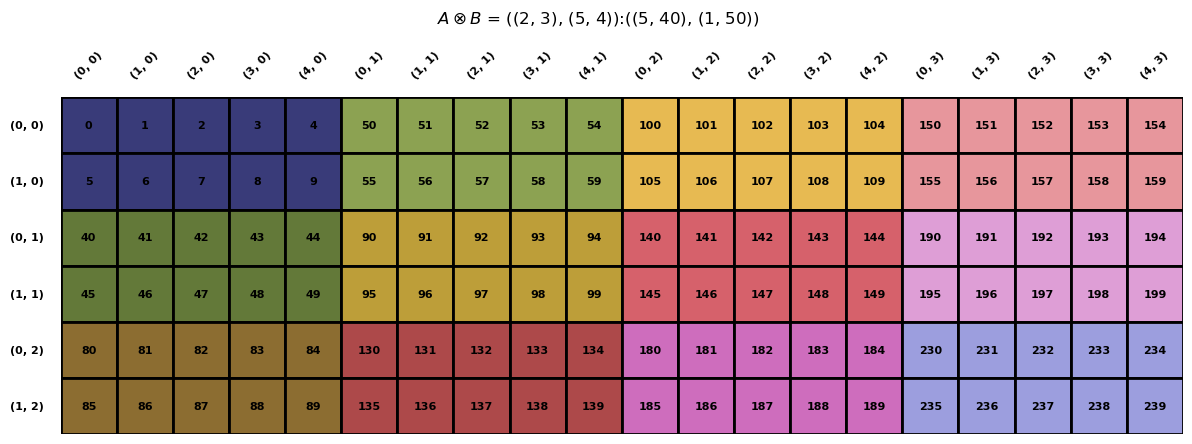

In [23]:
A = Layout.from_string('(2,5):(5,1)').visualize('A', color_cycle=10)
B = Layout.from_string('(3,4):(20,10)').visualize('B', color_cycle=3)
A.logical_product(B, by_mode=True).visualize('$A \\otimes B$', color_cycle=10)

To understand how the product operation achieves the desired effect, let us break it down into steps and mode by mode.

For the 1st mode, we expect the result $C_1$ to contain $A_1$ as its first "tile". Specifically,
* $\operatorname{size}(C_1) = \operatorname{size}(A_1) \times \operatorname{size}(B_1) = 2 \times 3 = 6$
* $\operatorname{stride-across-tiles}(C_1) = \operatorname{size}(A_1) \times \operatorname{stride}(B_1) = 2 \times 20 = 40$

How does the product operation achieve these? All we know is the formula $C_1 := (A_1, \tilde A_1 \circ B_1)$.

First, to avoid the "pointer" $B_1$ points anywhere out-of-bound, we allocate $\tilde{A_1} =\operatorname{complement}(A_1, x)$ with a cortarget $x$ large enough to cover $\operatorname{cosize}(B_1)=41$.
According to the complement formula [2], the resulting $\operatorname{size}(\tilde{A_1}) = (d_1 / 1) \cdot (d_2 / (s_1 d_1)) ... (x/ (s_{k-1} d_{k-1})) \ge x / \operatorname{size}(A_1)$.
Hence it is safe to set $\operatorname{size}(\tilde{A_1}) \ge x / \operatorname{size}(A_1) = \operatorname{cosize}(B_1) = 41$ which implies we need to set $x = \operatorname{size}(A_1) \times \operatorname{cosize}(B_1)$.

Second, to meet the expected product layout requirements, the intermediate steps
* use $B_1$ as the pointer which implies that $\tilde A_1 \circ B_1$ is the same size of $B_1$. The later concatenation operation $(A_1, \tilde A_1 \circ B_1)$ will ensure $C_1$ to have a shape equal to $\operatorname{size}(A_1) \times \operatorname{size}(B_1)$;
* for "stride across tiles", assume a unit stride of $B_1$ (i.e., $20$) will be pointing to the $y$-th column of $\tilde A_1$. Assuming $A_1=s:d$, the stride (alone n-axis) of $\tilde A_1$ is $s \times d = 2 \times 5 = 10$ due to the formula of complement [2], and $y = 20 / \operatorname{height}(\tilde A_1) = 20 / d$. Therefore it will point at index $(s \times d) \times (20 / d) = s \times 20$ which is exactly $\operatorname{size}(A_1) \times \operatorname{stride}(B_1)$.

size =  2 * 41 = 82
complement: sorted (stride, shape) = [(5, 2)]
complement: + 5/1:1
complement: + 82/10:10
composite: + min(5/20, 3):1*20
composite: + 3:10*4



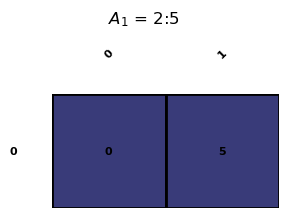

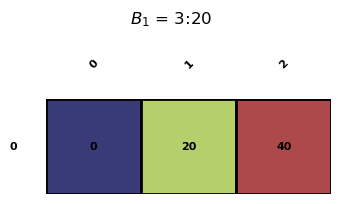

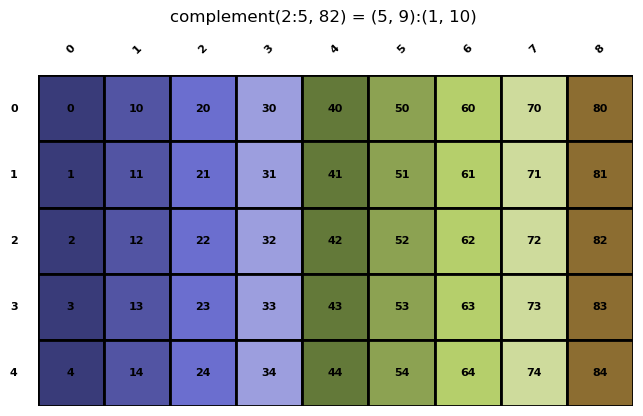

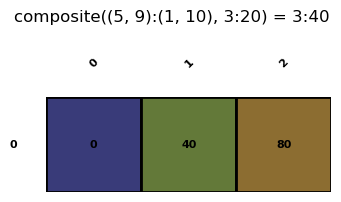

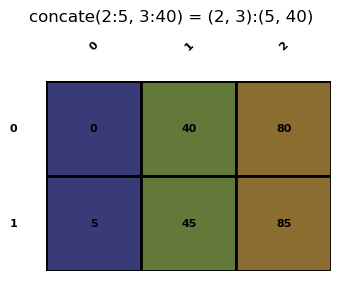

In [24]:
A1 = Layout.from_string('2:5').visualize('$A_1$', color_cycle=10)
B1 = Layout.from_string('3:20').visualize('$B_1$', color_cycle=3)
print('size = ', A1.size(), '*', B1.cosize(), '=', size:=A1.size() * B1.cosize())
_ = A1.logical_product(B1, visualize_steps=True, verbose=True, color_cycle=10)

Similarly, for the 2nd mode:

size =  5 * 31 = 155
complement: sorted (stride, shape) = [(1, 5)]
complement: + 1/1:1
complement: + 155/5:5
composite: + 4:5*10



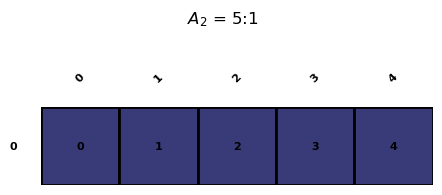

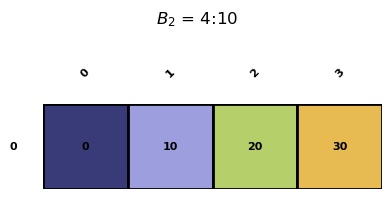

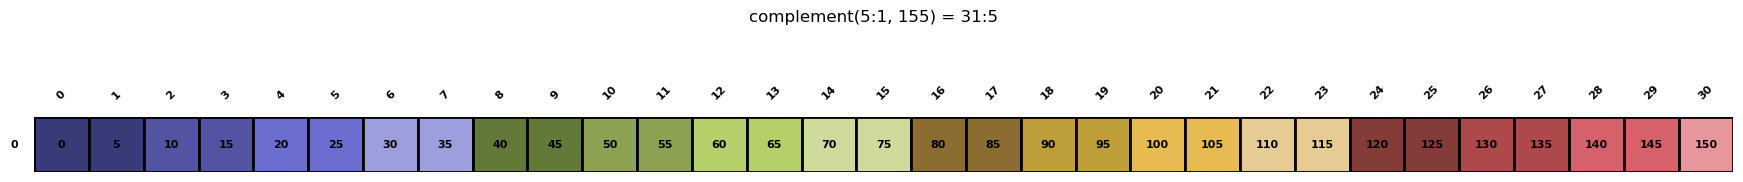

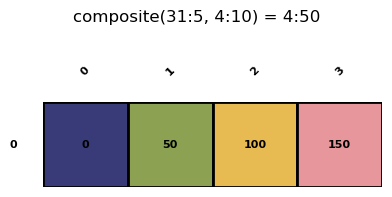

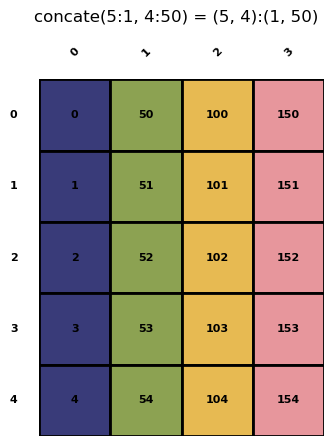

In [25]:
A2 = Layout.from_string('5:1').visualize('$A_2$', color_cycle=10)
B2 = Layout.from_string('4:10').visualize('$B_2$', color_cycle=3)
print('size = ', A2.size(), '*', B2.cosize(), '=', size:=A2.size() * B2.cosize())
_ = A2.logical_product(B2, visualize_steps=True, verbose=True, color_cycle=10)

## 1D Regular Product

Now we turn to some 1D examples taken from CuTe docs [1].

In [26]:
import matplotlib.pyplot as plt

layout = Layout.from_string('((2, 2), (2, 3)):((4, 1), (2, 8))')
table = layout.capture_idx2crd_table()

def example1_color_map(index, cycle=None):
    _, (x0, x1) = table[index]
    mapped_index = Layout.from_string('(2,3)').crd2idx((x0, x1))
    return default_color_map(mapped_index)

Be careful when $A$ is not rank 1 -- because the definition of complement requires sorting strides among different modes, it may require re-thinking the calculation of cross-tile strides. As $A$ will be transposed after sorting the strides in the below example, we should think in terms of a transposed A to predict it outcome shape:
* the transposed m-axis is $s_1:d_1 = 2:1$, which will be first indexed by $B_1 = 1$, with a stride of $s_1 \times d_1 = 2$.
* the transposed n-axis is $s_2:d_2 = 2:4$, which will be first indexed by $B_2 = 2$, with a stride of $s_2 \times d_2 = 8$.

complement: sorted (stride, shape) = [(1, 2), (4, 2)]
complement: + 1/1:1
complement: + 4/2:2
complement: + 24/8:8
composite: + min(2/1, 6):2*1
composite: + 3:8*1



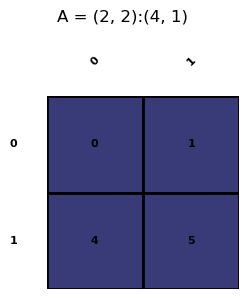

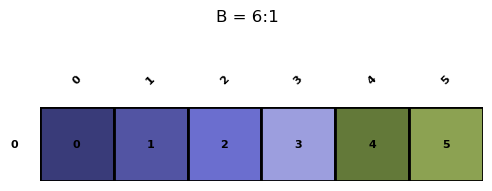

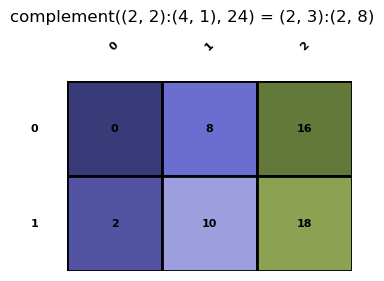

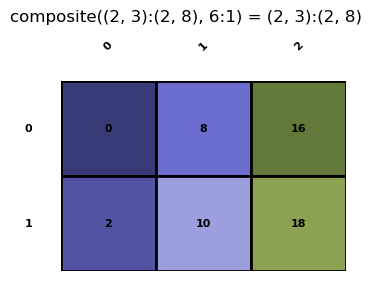

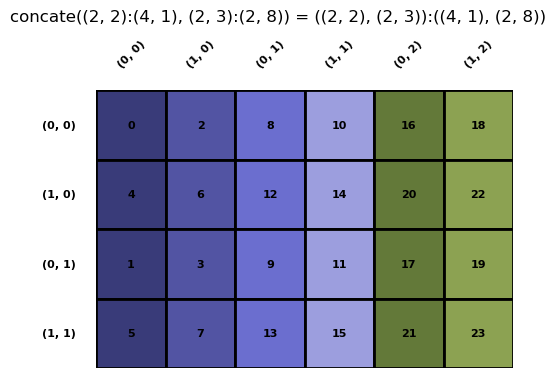

In [27]:
A = Layout.from_string('(2,2):(4,1)').visualize('A', color_map=example1_color_map)
B = Layout.from_string('6:1').visualize('B')
_ = A.logical_product(B, visualize_steps=True, verbose=True, color_map=example1_color_map)

Another example:

complement: sorted (stride, shape) = [(1, 2), (4, 2)]
complement: + 1/1:1
complement: + 4/2:2
complement: + 32/8:8
composite: + min(2/2, 4):2*2
composite: + 4:8*1

composite: + min(2/1, 2):2*1
composite: + 1:8*1



((2, 2), (4, 2)):((4, 1), (8, 2))

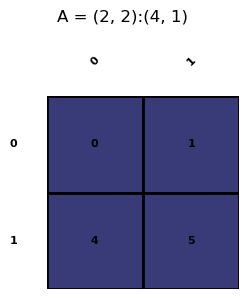

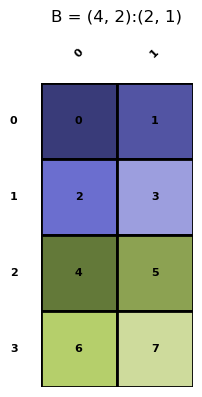

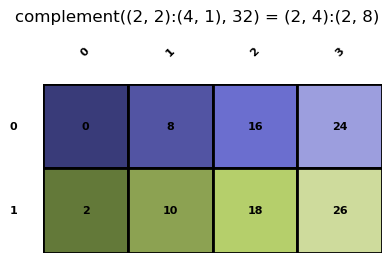

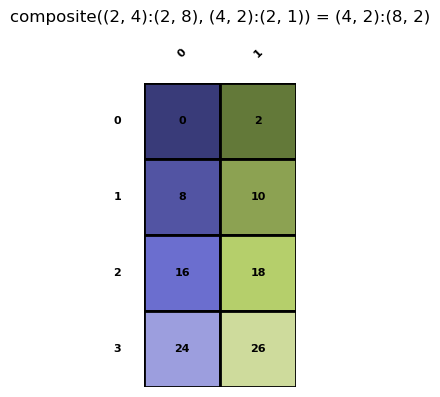

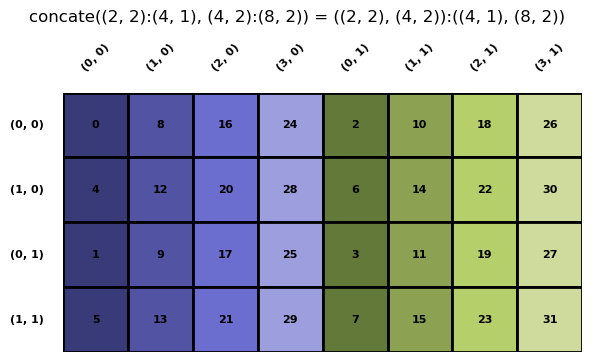

In [28]:
layout = Layout.from_string('((2, 2), (4, 2)):((4, 1), (8, 2))')
table = layout.capture_idx2crd_table()

def example2_color_map(index, cycle=None):
    _, (x0, x1) = table[index]
    mapped_index = Layout.from_string('(4, 2)').crd2idx((x0, x1))
    return default_color_map(mapped_index)
    
A = Layout.from_string('(2,2):(4,1)').visualize('A', color_map=example2_color_map)
B = Layout.from_string('(4,2):(2,1)').visualize('B')
A.logical_product(B, visualize_steps=True, verbose=True, color_map=example2_color_map)

## Blocked Product

Instead of using by-mode product, it is recommended to use an operation called `blocked_product` which applies a regular product first, then "unzip" it to form span-mode tiles.

complement: sorted (stride, shape) = [(1, 5), (5, 2)]
complement: + 1/1:1
complement: + 5/5:5
complement: + 240/10:10
composite: + 3:10*4

composite: + 4:10*5

((2, 5), (3, 4)):((5, 1), (40, 50))
((2, 3), (5, 4)):((5, 40), (1, 50))


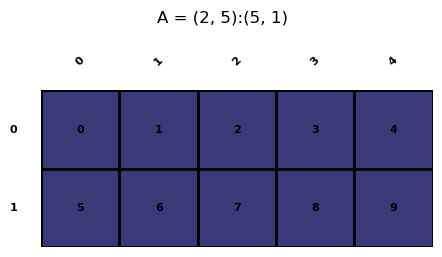

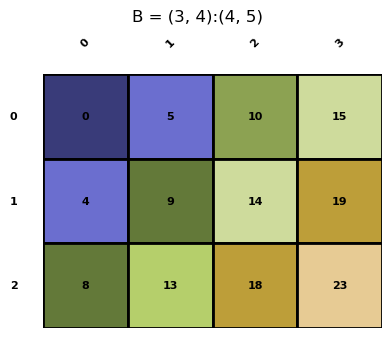

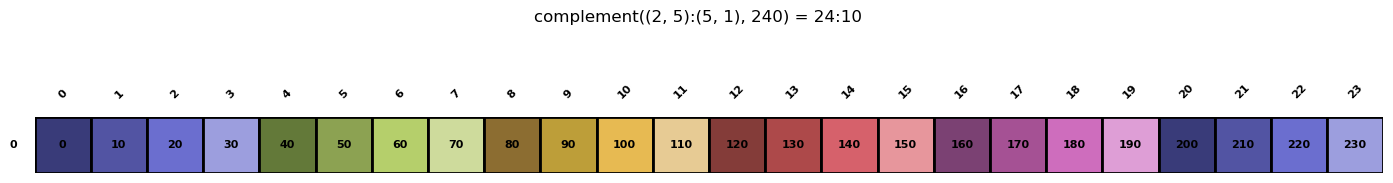

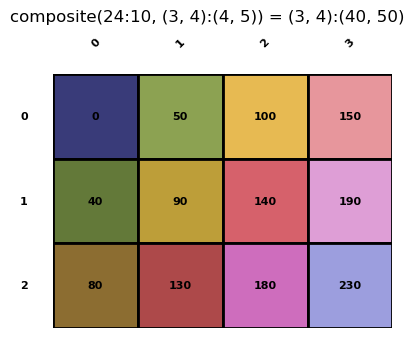

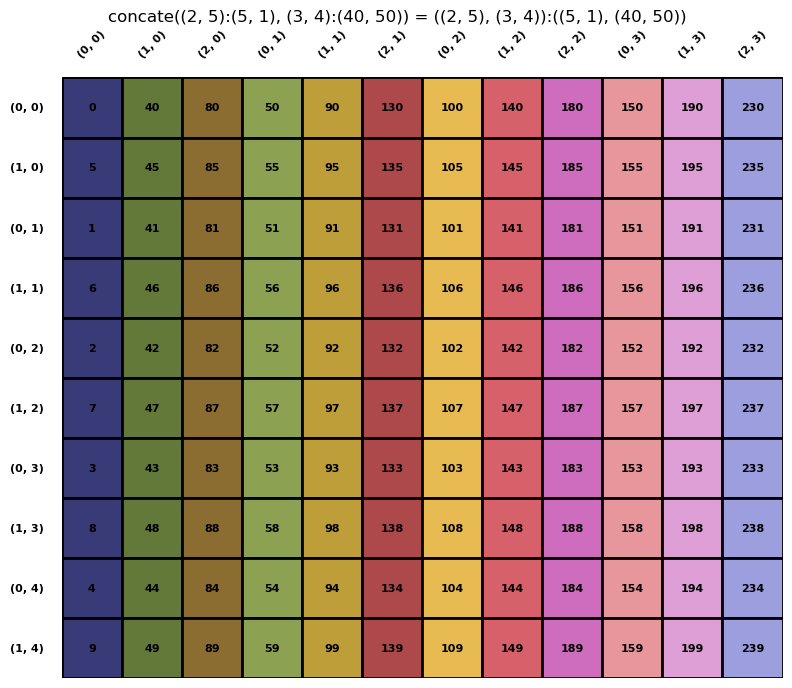

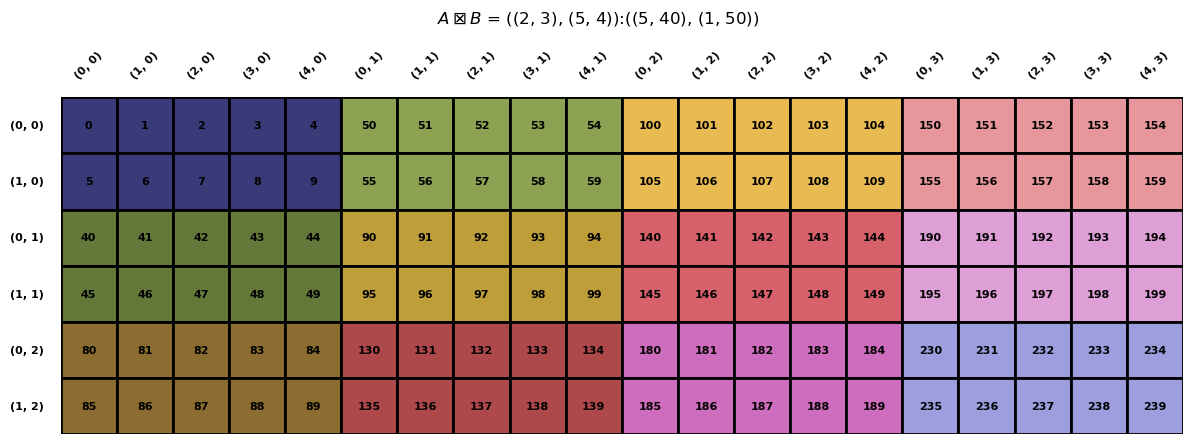

In [61]:
A = Layout.from_string('(2,5):(5,1)').visualize('A', color_cycle=10)
B = Layout.from_string('(3,4):(4,5)').visualize('B', color_cycle=2)
print(A.logical_product(B, visualize_steps=True, verbose=True, color_cycle=10))
print(A.blocked_product(B).visualize(r'$A \boxtimes B$', color_cycle=10))

Another example:

In [68]:
layout = Layout.from_string('((2, 3), (3, (2, 2))):((6, 24), (1, (3, 12)))')
table = layout.capture_idx2crd_table()

def example3_color_map(index, cycle=None):
    #return default_color_map(0)
    _, (x0, (x1, x2)) = table[index]
    mapped_index = Layout.from_string('(3, (2, 2))').crd2idx((x0, (x1, x2)))
    return default_color_map(mapped_index)

complement: sorted (stride, shape) = [(6, 2), (24, 3)]
complement: + 6/1:1
complement: + 24/12:12
complement: + 72/72:72
composite: + min(6/1, 3):1*1
composite: + 1:12*1

composite: + min(6/3, 4):1*3
composite: + 2:12*1

((2, 3), (3, (2, 2))):((6, 24), (1, (3, 12)))
((2, 3), (3, (2, 2))):((6, 1), (24, (3, 12)))


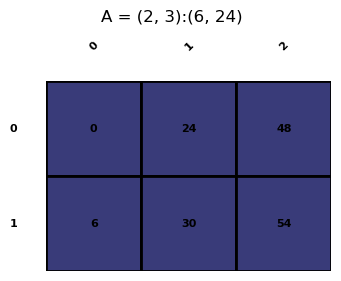

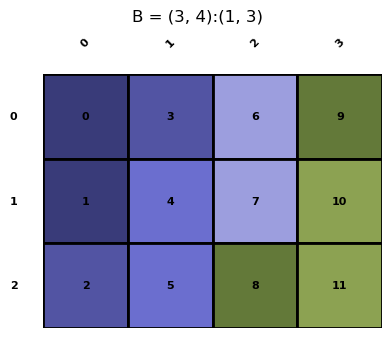

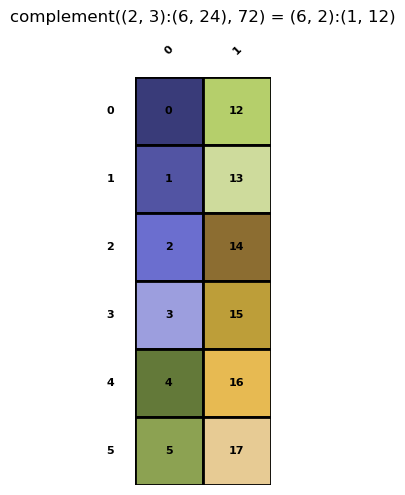

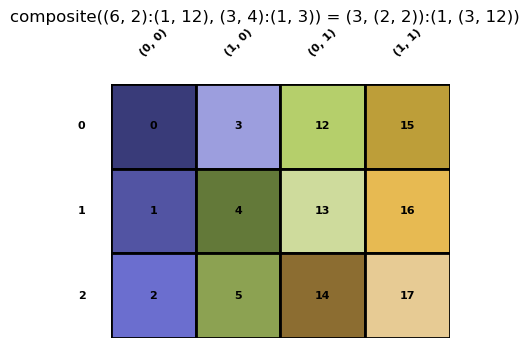

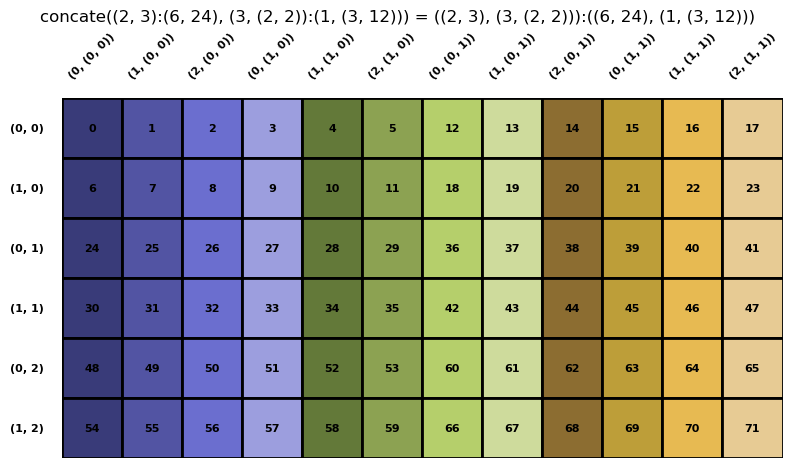

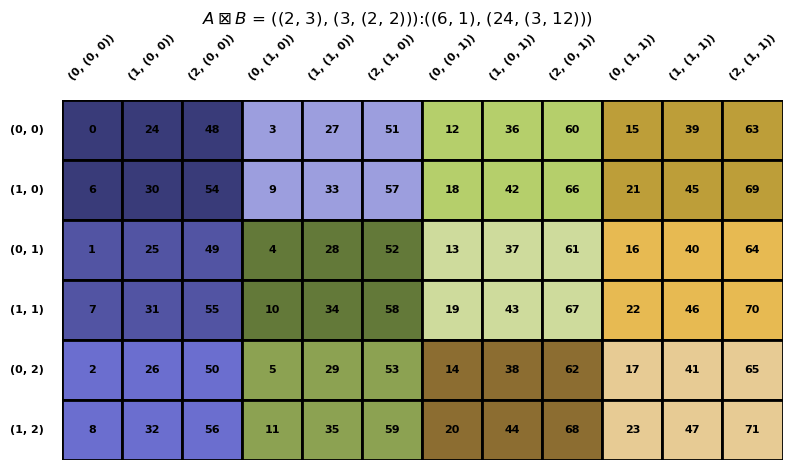

In [69]:
A = Layout.from_string('(2,3):(6,24)').visualize('A', color_map=example3_color_map)
B = Layout.from_string('(3,4):(1,3)').visualize('B', color_cycle=2)
print(A.logical_product(B, visualize_steps=True, verbose=True, color_map=example3_color_map))
print(A.blocked_product(B).visualize(r'$A \boxtimes B$', color_map=example3_color_map))

## Reference
[1] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/media/docs/cpp/cute/02_layout_algebra.md

[2] [Complement Formula](layout_basics.ipynb#Complement)